#開始

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### グラフ表示

[0.0, 1.0]


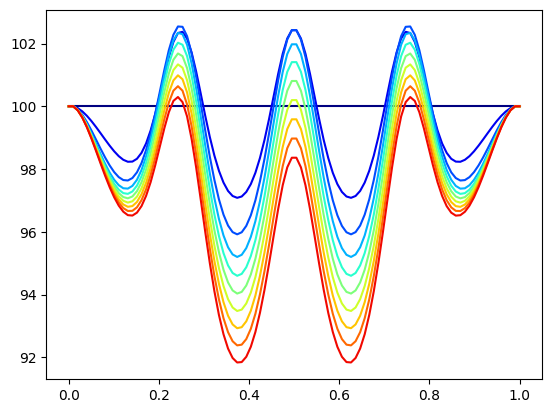

In [94]:
# parameters
t_span = [0.0,1.0]
t_eval = np.linspace(*t_span,10) # time for sampling
# init
nx = 100
x_span = [0.,1.0]
x  = np.linspace(*x_span,nx)
Δx = 1/(nx)
u  =  np.zeros_like(x)
init   = u
k0 = 1.0
h2 = 10**(-4)
p0 = 0.01/3.0
s = 1+0.0033*np.exp(-500*(x-0.25)**2)+0.0033*np.exp(-500*(x-0.75)**2)+0.0033*np.exp(-500*(x-0.5)**2)#np.cos(50*x)#*
ds =  np.gradient(s, Δx)
dds = np.gradient(ds, Δx)
# ODEs
def ODEs(t,u,Δx):
    du = - k0* 1/2 *dds[2:-2]\
         - k0* h2* 1/3*ds[2:-2]*np.diff(u,3)[1:]/(Δx**3)\
         - k0* h2* 1/3*s[2:-2]*np.diff(u,4)/(Δx**4)\
         + k0* p0* 1/3*s[2:-2]*np.diff(u,2)[1:-1]/(Δx**2)\
         - 0.05
#         - k0* ds[2:-2]*u[2:-2] * np.convolve(u,[3.0,-4.0,1.0],'valid')[1:-1]/(2*Δx)
    return np.hstack([0.,0.,du,0.,0.])
# solve
sol = solve_ivp(ODEs,t_span,init,method="RK45",t_eval=t_eval,args=(Δx,),rtol=1e-8)

cmap = plt.get_cmap('jet')
Np = len(sol.t)
for i in range(Np):
    plt.plot(x,100+100*sol.y[:,i],c=cmap(i/Np))
print(t_span)

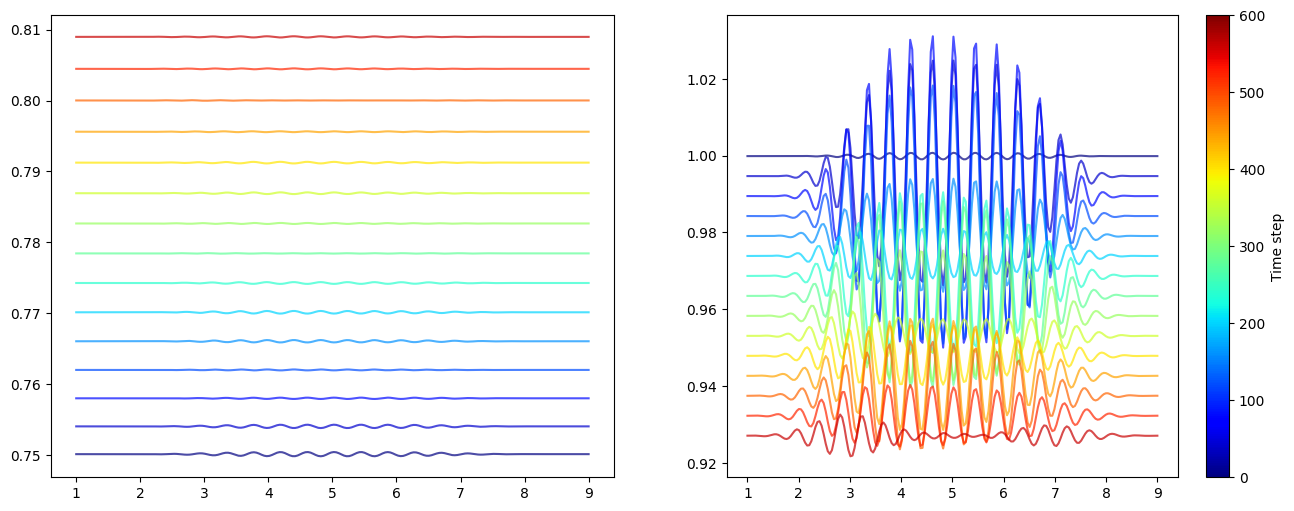

In [180]:
# パラメータ設定
mu = 0.8    # 粘度
sigma = 1 # 表面張力
E = 0.013     # 蒸発速度D = 1   # 拡散係数
r_min, r_max = 1.0, 9.0  # 計算範囲
Nr = 200    # 空間分割数
Nt = 600    # 時間ステップ数
dt = 0.01 # 時間刻み (小さくする)600*0.01=6= 600s
dr = (r_max - r_min) / Nr  # 空間刻み
dσ_dc = 2.3
p0 = 0.011/3.0
# 位置 r の離散化
r = np.linspace(r_min, r_max, Nr)
h = np.ones(Nr)
c = 0.75 + 0.0003 * np.exp(-0.05*(r-5)**4)* np.cos((15*r))  # 初期条件 c(r,0) = 1 + 0.1 sin(r)

# カラーマップの設定
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, Nt))  # Ntステップ分の色を設定
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1行2列のグラフ
#fig, ax = plt.subplots(figsize=(8, 6)) # Create a figure and an axes object

# 小さすぎる値を防ぐためのしきい値
epsilon = 1e-6
# 時間発展ループ
for step in range(Nt):
    # h の最小値を制限 (ゼロ割り防止)
    h = np.maximum(h, epsilon)
    c = np.maximum(c, epsilon)

    # Laplacian (h の二階微分) の計算
    h_rr = np.gradient(np.gradient(np.gradient(h, dr) * r, dr) / r)

    # Q の計算
    term1 = (r * sigma * h**3 / (3 * mu)) * h_rr
    term2 =  dσ_dc * (h**2 / (2 * mu)) * np.gradient(c, dr)
    Q = term2+term1*10**(-4.0)

    # h の時間発展
    Q_r = np.gradient(r*Q, dr) / r
    pg  = p0/3*np.gradient(np.gradient(h, dr), dr)
    h_new = h - dt * (Q_r -pg+ E)

    # c の時間発展
    Q_c = (Q / h) * np.gradient(c, dr)
#    D_term = np.gradient(r* h * np.gradient(c, dr), dr) / (r * h)
    E_term = E *c/ h
    c_new = c - dt * (Q_c - E_term)#-D_term*10**(-5)

    if step % 40 == 0:
        ax1.plot(r, c_new, color=colors[step], alpha=0.7)
        ax2.plot(r, h_new, color=colors[step], alpha=0.7)

    # h をプロット (時間ごとに色を変える)
    #ax.plot(r, h_new, color=colors[step], alpha=0.7) # Plot on the axes object

    # 更新
    h, c = h_new, c_new

# カラーバーを追加
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=Nt))
cbar = fig.colorbar(sm, ax=ax2) # Specify the axes to steal space from
cbar.set_label("Time step")

# グラフ設定
ax.set_xlabel("r") # Use ax.set_xlabel instead of plt.xlabel
ax.set_ylabel("h(r)") # Use ax.set_ylabel instead of plt.ylabel
ax.set_title("Evolution of h(r) over time") # Use ax.set_title instead of plt.title
plt.show()
